<a href="https://colab.research.google.com/github/aleshkovskijjaaa/-Gas-well-retirement-forecast-model/blob/main/pupit2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Тренировка размеченной модели**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
pip install darts

In [ ]:
from darts import TimeSeries
import datetime
import matplotlib.pyplot as plt
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape

Размеченные данные

In [ ]:
df_1 = pd.read_csv('/content/sng_dataset_v1_valid1_with_anom_marked2.csv')
df_1['DT_1']= pd.to_datetime(df_1['DT_1'])

Davl_column = "DSHORTT1138P2300058"
valuable_column1 = 'T1138P6000096'
valuable_column2 = 'T1138P2600012'
val_cols = ['WELL_ID',Davl_column,valuable_column1,valuable_column2,'anomaly',
           'DT_1']
df_1f = df_1[val_cols].copy()
df_1f.tail(1)

,WELL_ID,DSHORTT1138P2300058,T1138P6000096,T1138P2600012,anomaly,DT_1
24841,226000188,0.0,0,0.0,0,2019-09-20 08:55:00


In [ ]:
skvazini = df_1f['WELL_ID'].unique()# блок дропа аномальных скважин
df_1a = df_1f.loc[df_1f['anomaly'] == 1]
anomal_skvazini = list(df_1a['WELL_ID'].unique())
for i in range(len(anomal_skvazini) - 1):
  df_1f = df_1f[df_1f['WELL_ID'] != anomal_skvazini[i]]

Фильтрованное светлое

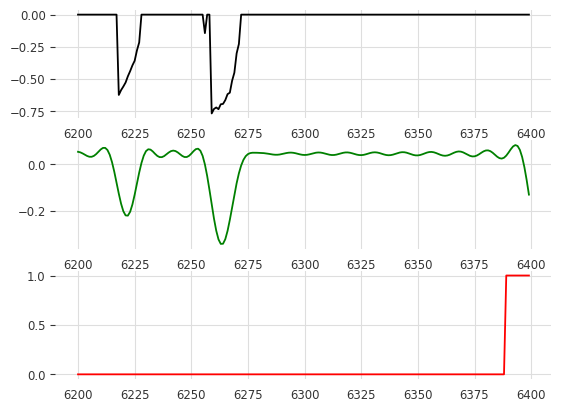

In [ ]:
# тестируем сглаживание с помощь преобразования Фурье
first_el = 6200
last_el = first_el + 200

first_h_k = 0.2
otsek_last = 0.08

def data_prep (stolb_0):
  fourier_coeffs = np.fft.fft(stolb_0)
  N = len(fourier_coeffs) - 1
  fourier_coeffs[1:int(N*(1-otsek_last))] = 0 # обнуляем средние гармоники
  fourier_coeffs[0] = fourier_coeffs[0] * first_h_k
  filtered_data = np.real(np.fft.ifft(fourier_coeffs))

  return filtered_data

df_1f['Fourier_filtered'] = data_prep(df_1f[Davl_column])


fig, ax = plt.subplots(3, 1)
df_1f[Davl_column][first_el:last_el].plot(ax=ax[0])
df_1f['Fourier_filtered'][first_el:last_el].plot(ax=ax[1],label="filter",color="g")
df_1f['anomaly'][first_el:last_el].plot(ax=ax[2],label="anomaly",color="r")
plt.show()

In [ ]:
df_1f['val_col1'] = data_prep(df_1f[Davl_column])
df_1f['val_col2'] = data_prep(df_1f[valuable_column1])
df_1f['val_col3'] = data_prep(df_1f[valuable_column2])

In [ ]:
# Load data into darts TimeSeries object
timeseries = TimeSeries.from_dataframe(df_1f, time_col='DT_1', freq='5T')
ts_ecg = timeseries[['val_col1','val_col2','val_col3']]
ts_anomaly = timeseries['anomaly']

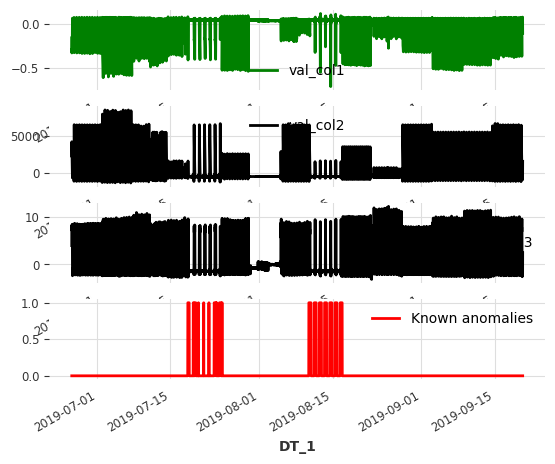

In [ ]:
fig, ax = plt.subplots(4, 1)
ts_ecg['val_col1'].plot(ax=ax[0], color="g")
ts_ecg['val_col2'].plot(ax=ax[1])
ts_ecg['val_col3'].plot(ax=ax[2])
ts_anomaly.plot(ax=ax[3], label="Known anomalies", color="r")
plt.show()

In [ ]:
# Create train and test dataset for demonstration
count = len(df_1f['val_col1'])
center = 6000
end = count-1
ts_ecg_train = ts_ecg[0:center]
ts_ecg_test = ts_ecg[center:end]
ts_anomaly_test = ts_anomaly[center:end]


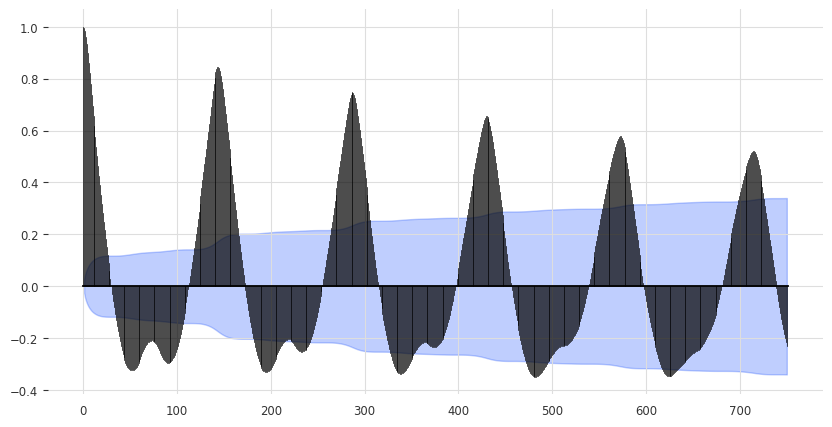

In [ ]:
from darts.utils.statistics import plot_acf

# Visualise signal auto correlation to identify most common periodicity
plot_acf(ts=ts_ecg_train['val_col1'], max_lag=750)
plt.show()

period = 170

https://unit8co.github.io/darts/generated_api/darts.models.forecasting.html

In [ ]:
from darts.metrics import mae, rmse
from darts.models import LinearRegressionModel
#from darts.models import RandomForest
#from darts.models import XGBModel
#from darts.models import LightGBMModel
#from darts.models import RegressionModel
from darts.ad.scorers import NormScorer, KMeansScorer
from darts.ad.anomaly_model.forecasting_am import ForecastingAnomalyModel

# Instatiate of a forecasting model - e.g. RegressionModel with a defined lag

forecasting_model = LinearRegressionModel(lags=period)
#forecasting_model = RandomForest(lags=period)
#forecasting_model = XGBModel(lags=period)
#forecasting_model = LightGBMModel(lags=period)
#forecasting_model = RegressionModel(lags=period)

# Instantiate the anomaly model with: one forecasting model, and one or more scorers (and corresponding parameters)
anomaly_model = ForecastingAnomalyModel(
    model=forecasting_model,
    scorer=[
        NormScorer(ord=1),
        KMeansScorer(k=50, window=2*period, component_wise=False)
        #DifferenceScorer
    ],
)

# Fit anomaly model
START = 2 * period
anomaly_model.fit(ts_ecg_train, start=START, allow_model_training=True)

In [ ]:
# Score with the anomaly model (forecasting + scoring)
anomaly_scores, model_forecasting = anomaly_model.score(
    ts_ecg_test, start=2*period, return_model_prediction=True
)

# Compute the MAE and RMSE on the test set
print(f"On testing set -> MAE: {mae(model_forecasting, ts_ecg_test)}, RMSE: {rmse(model_forecasting, ts_ecg_test)}")

On testing set -> MAE: 9.087574893571065e-09, RMSE: 1.2289898950325642e-08


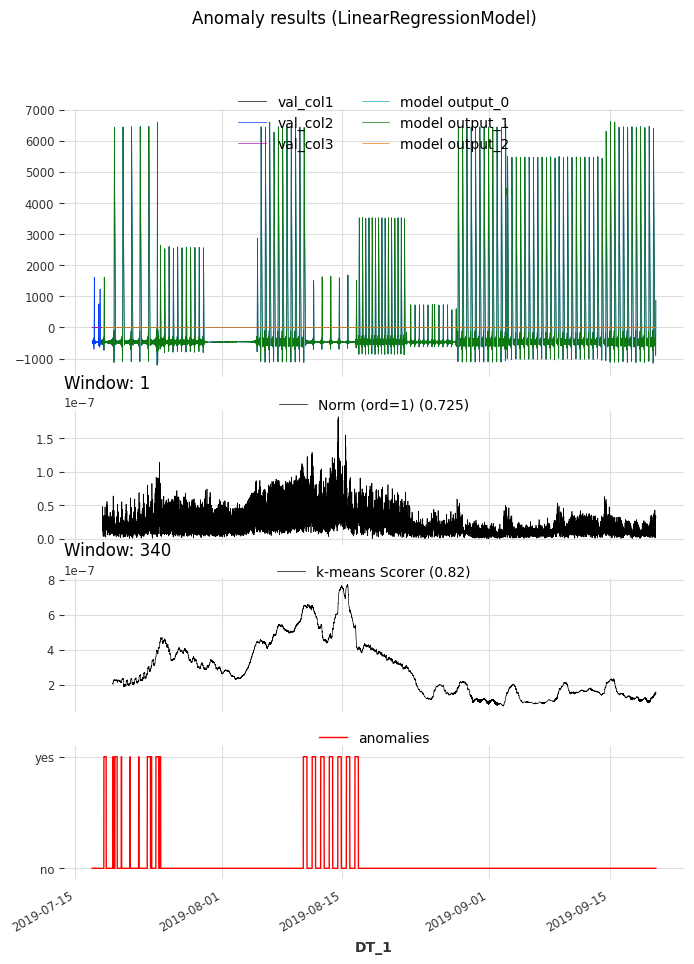

In [ ]:
# Visualize anomalies
anomaly_model.show_anomalies(
    series=ts_ecg_test,
    actual_anomalies=ts_anomaly_test,
    start=START,
    metric="AUC_ROC",
)
plt.show()

In [ ]:
df_2 = pd.read_csv('/content/sng_dataset_v1_valid2_with_anom_marked2.csv')
df_2['DT_1']= pd.to_datetime(df_2['DT_1'])
#df_2.drop(df_2.columns[[3]], axis = 1, inplace = True) #дропаем столбец дат настоящих
#df_2.drop(df_2.columns[[-2]], axis = 1, inplace = True) #дропаем c размеченными аномал
df_2.tail(1)

,Unnamed: 0,WELL_ID,UUID,DT,UNIXDT,T1138P6000096,T1138P6000315,DMIDT1138P4000064,DSHORTT1138P4000064,DLONGT1138P4000064,...,DLONGT1205P2300000,T1205P2300000,T1138P4000064,T1138P2600012,T1138P600050,DMIDT1138P2300058,DSHORTT1138P2300058,DLONGT1138P2300058,anomaly,DT_1
22568,22568,226000188,226000188026136000,2019-05-30 12:00:00,1559217600,2700,0,-5.331749,-20.107881,-4.267554,...,-0.00015,1.603128,47,18.5,0.557,-0.620364,-0.799724,-0.58807,0,2019-08-21 11:45:00


In [ ]:
#создание фильтрованного датасета
val_cols = ['WELL_ID',Davl_column,valuable_column1,valuable_column2,'anomaly',
           'DT_1']
df_2f = df_2[val_cols].copy()

df_2f['val_col1'] = data_prep(df_2f[Davl_column])
df_2f['val_col2'] = data_prep(df_2f[valuable_column1])
df_2f['val_col3'] = data_prep(df_2f[valuable_column2])

In [ ]:
timeseries_2 = TimeSeries.from_dataframe(df_2f, time_col='DT_1')
ts_ecg_2 = timeseries_2[['val_col1','val_col2','val_col3']]
ts_anomaly_2 = timeseries_2['anomaly']

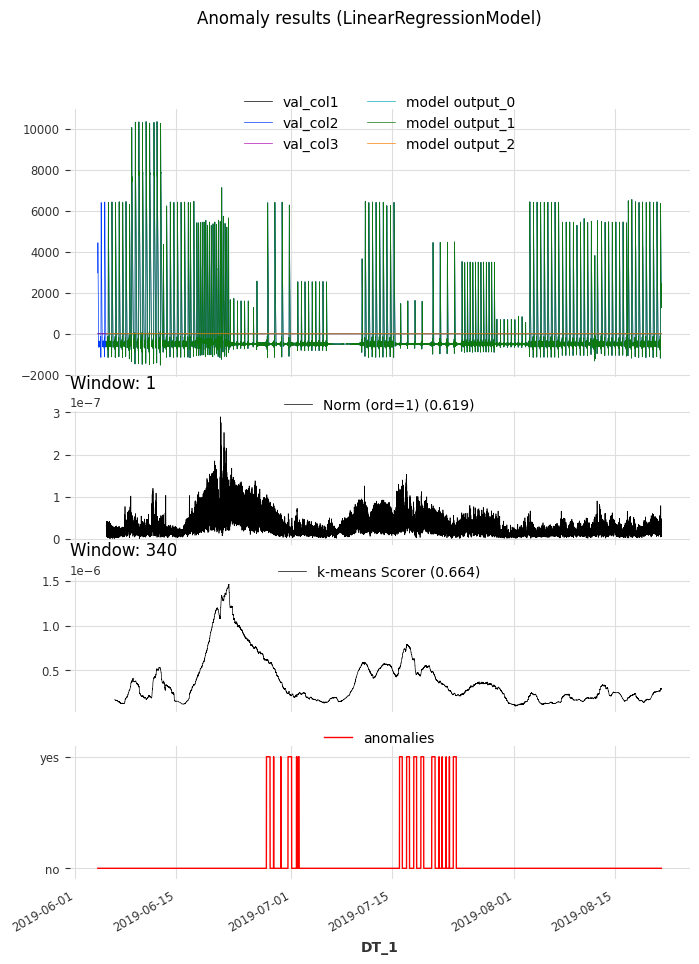

In [ ]:
# Visualize anomalies
anomaly_model.show_anomalies(
    series=ts_ecg_2,
    actual_anomalies=ts_anomaly_2,
    start=START,
    metric="AUC_ROC",
)
plt.show()